In [ ]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython tensorflow_addons opencv-python requests

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# AUTOENCODERS

## Overview

An autoencoder, also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of <b>unlabeled</b> inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression. 

Autoencoders are based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of Deep Belief Networks (DBN).

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/VAE/mod_ID_13_final.png" width=400>

## Autoencoder Structure 

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/VAE/deep_autoencoder.png">

An autoencoder can be divided in two parts, the <b>encoder</b> and the <b>decoder</b>.

The encoder needs to compress the representation of an input. In this case we are going to reduce the dimension. The decoder works like encoder network in reverse. It works to recreate the input, as closely as possible. This plays an important role during training, because it forces the autoencoder to select the most important features in the compressed representation.

<h2>Training: Loss function</h2>

An autoencoder uses the Loss function to properly train the network. The Loss function will calculate the differences between our output and the expected results. After that, we can minimize this error with gradient descent. There are more than one type of Loss function, it depends on the type of data.The following is the formula for binary values.

$$l(f(x)) = - \sum_{k} (x_k log(\hat{x}_k) + (1 - x_k) \log (1 - \hat{x}_k) \ )$$

For binary values, we can use an equation based on the sum of Bernoulli's cross-entropy.  $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output. We use this function so that if $x_k$ equals to one, we want to push $\hat{x}_k$ as close as possible to one. The same if $x_k$ equals to zero. If the value is one, we just need to calculate the first part of the formula, that is, $- x_k log(\hat{x}_k)$. Which, turns out to just calculate $- log(\hat{x}_k)$. And if the value is zero, we need to calculate just the second part, $(1 - x_k) \log (1 - \hat{x}_k) \ )$ - which turns out to be $log (1 - \hat{x}_k) $.The following is the formula for real values.

$$l(f(x)) = - \frac{1}{2}\sum_{k} (\hat{x}_k- x_k \ )^2$$

As the above function would behave badly with inputs that are not 0 or 1, we can use the sum of squared differences for our Loss function.

As it was with the above example, $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output, and we want to make our output as similar as possible to our input.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
%matplotlib inline

Now, let's give the parameters that are going to be used by our NN.

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
batch_size = 128
epochs = 50

# Network Parameters
hidden_1 = 128 # 1st layer num features.
hidden_2 = 64 # 2nd layer num features (the latent dim).

In [3]:
from tensorflow.keras.datasets import mnist, fashion_mnist

def load_data(choice='mnist', labels=False):
    if choice not in ['mnist', 'fashion_mnist']:
        raise ('Choices are mnist and fashion_mnist')
    
    if choice is 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train, X_test = X_train / 255., X_test / 255.
    X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])
    X_train = X_train.astype(np.float32, copy=False)
    X_test = X_test.astype(np.float32, copy=False)
    
    if labels:
        return (X_train, y_train), (X_test, y_test)
    
    return X_train, X_test


def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (28, 28)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (28, 28)), aspect='auto')
    plt.tight_layout()

In [4]:
def plot_digits(X, y, encoder, batch_size=128):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.show()
    
    
def generate_manifold(decoder):
    """Generates a manifold of MNIST digits from a random noisy data.

    Parameters:
    ----------
    decoder: Model
        A Keras Model instance
    """
    
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit        
    
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

This code contains two functions, `plot_digits` and `generate_manifold`, for visualizing the performance of an autoencoder in the latent space. `plot_digits` function transforms test data into mean vectors in the latent space through an encoder and displays the distribution of these vectors on a two-dimensional plane, allowing observation of the distribution of different classes of data in the latent space. `generate_manifold` function generates a two-dimensional plane, maps it back to the data space, and generates corresponding MNIST digits for visualization, showing the digit features corresponding to different positions in the latent space. These functions help understand how the autoencoder learns data representations and effectively represents and generates data in the latent space.

Now we need to create our encoder/decoder. For this, we are going to use sigmoidal functions. Sigmoidal functions delivers great results with this type of network. This is due to having a good derivative that is well-suited to backpropagation.

**Encoder**

In [5]:
inputs = kr.Input(shape=(num_features, ))
encoder = kr.layers.Dense(hidden_1, activation='sigmoid')(inputs)
encoder = kr.layers.Dense(hidden_2, activation='sigmoid')(encoder)
encoder_model = kr.Model(inputs, encoder, name='encoder')
encoder_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________


**Decoder**

In [6]:
latent_dim = kr.Input(shape=(hidden_2, ))
decoder = kr.layers.Dense(hidden_1, activation='sigmoid')(latent_dim)
decoder = kr.layers.Dense(num_features, activation='sigmoid')(decoder)
decoder_model = kr.Model(latent_dim, decoder, name='decoder')
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 109,456
Trainable params: 109,456
Non-trainable params: 0
_________________________________________________________________


**Autoencoder Model**

In [7]:
outputs = decoder_model(encoder_model(inputs))
mnist_model = kr.Model(inputs, outputs )
mnist_model.compile(optimizer='adam', loss='mse')
mnist_model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 64)                108736    
_________________________________________________________________
decoder (Model)              (None, 784)               109456    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [8]:
X_train, X_test = load_data('mnist')
mnist_model.fit(x=X_train, y=X_train, batch_size=batch_size, shuffle=False, epochs=epochs)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0707
Epoch 2/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0593
Epoch 3/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0477
Epoch 4/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0394
Epoch 5/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0362
Epoch 6/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0322
Epoch 7/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0293
Epoch 8/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0267
Epoch 9/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0243
Epoch 10/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0222
Epoch 

Let's simply visualize our graphs!

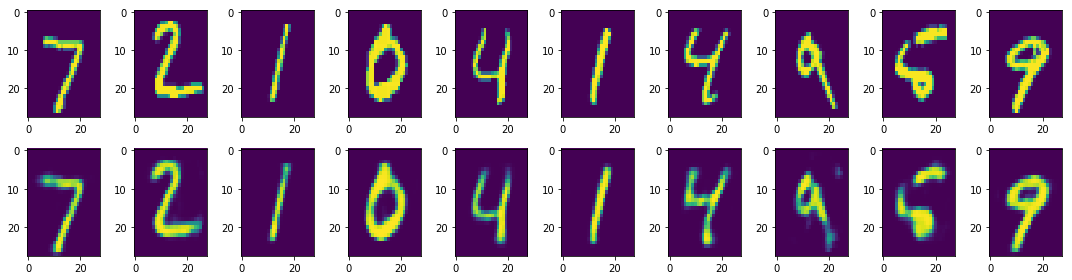

In [9]:
y_true = X_test[:10]
y_pred = mnist_model.predict(y_true)
plot_predictions(y_true, y_pred)

## Fashion MNIST

Let's try our network with fashion mnist to see how well it performs.

In [10]:
# Encoder
inputs = kr.Input(shape=(num_features, ))
encoder = kr.layers.Dense(hidden_1, activation='sigmoid')(inputs)
encoder = kr.layers.Dense(hidden_2, activation='sigmoid')(encoder)
encoder_model = kr.Model(inputs, encoder, name='encoder')
encoder_model.summary()

# Decoder
latent_dim = kr.Input(shape=(hidden_2, ))
decoder = kr.layers.Dense(hidden_1, activation='sigmoid')(latent_dim)
decoder = kr.layers.Dense(num_features, activation='sigmoid')(decoder)
decoder_model = kr.Model(latent_dim, decoder, name='decoder')
decoder_model.summary()

# AE
outputs = decoder_model(encoder_model(inputs))
fmnist_model = kr.Model(inputs, outputs )
fmnist_model.compile(optimizer='adam', loss='mse')
fmnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dens

In [11]:
X_train, X_test = load_data('fashion_mnist')
fmnist_model.fit(x=X_train, y=X_train, batch_size=batch_size, shuffle=False, epochs=epochs)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/50
60000/60000 [==============================] - 2s 34us/sample - loss: 0.0629
Epoch 2/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0381
Epoch 3/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0292
Epoch 4/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0252
Epoch 5/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0233
Epoch 6/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0219
Epoch 7/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0208
Epoch 8/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0197
Epoch 9/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0188
Epoch 10/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0181
Epoch 11/50
60000/60000 [==============================]

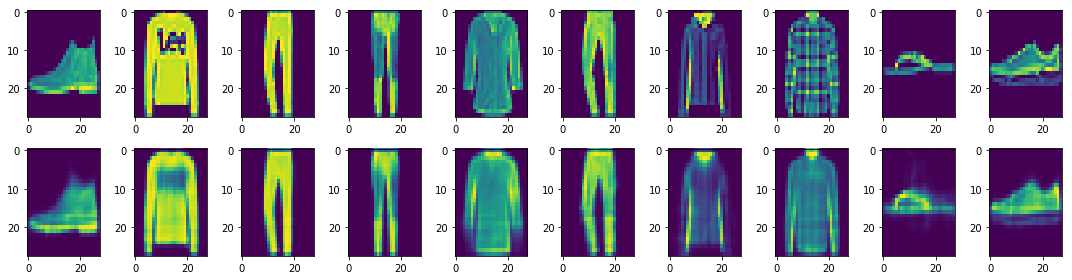

In [12]:
y_true = X_test[:10]
y_pred = fmnist_model.predict(y_true)
plot_predictions(y_true, y_pred)

As can be seen construction was okay not perfect due to some noise in the images. Increasing layer sizes may help.

## Your turn! 🚀

Assignment - [Denoising autoencoder](../assignments/base-denoising-autoencoder-dimension-reduction.ipynb)

## Acknowledgments

Thanks to [Fazil T](https://github.com/lordsoffallen) for creating the open-source project [kaggle](https://www.kaggle.com/) for creating the open-source courses [Variantional Autoencoders(VAE)](https://www.kaggle.com/code/fazilbtopal/variantional-autoencoders-vae). They inspire the majority of the content in this chapter.